# Assignment 1

# Density estimation using Real NVP

Normalizing flows is the class of probabilistic models that provides flexible parametrical probabilistic models, where the probability density function can be computed exactly. In the assignment, we will consider a real-valued non-volume preserving normalizing flows (Real NVP) -- a special case of normalizing flow.

#### Problem setting

Our goal is to train a generative network $g_\theta:  Z \rightarrow X, g = f^{-1}$ that maps latent variable $z \sim p(z)$ to a sample $x \sim p(x)$. Where $p(z)$ is a prior distibiution and $p(x)$ is a data distibution. An illustrative example is provided below.

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/2d-example.png)

#### Change of variable formula

Given an observed data variable $x \in X$,
a simple prior probability distribution $p_{Z}$ on a latent variable $z \in Z$,
and a bijection $f: X \rightarrow Z$ (with $g = f^{-1}$),
the change of variable formula defines a model distribution of $X$ by
<!-- \begin{align}
p_{X}(x) &= p_{Z}\big(f(x)\big) \left|\det\left(\cfrac{\partial f(x)}{\partial x^T} \right)\right|
\label{eq:change-variables}\\
\log\left(p_{X}(x)\right) &= \log\Big(p_{Z}\big(f(x)\big)\Big) + \log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
,
\end{align} -->

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/f.png)
where $\frac{\partial f(x)}{\partial x^T}$ is the Jacobian of $f$ at $x$.

Exact samples from the resulting distribution can be generated by using the inverse transform sampling rule. A sample $z \sim p_{Z}$ is drawn in the latent space, and its inverse image $x = f^{-1}(z) = g(z)$ generates a sample in the original space. Computing the density at a point $x$ is accomplished by computing the density of its image $f(x)$ and multiplying by the associated Jacobian determinant $\det\left(\frac{\partial f(x)}{\partial x^T}\right)$.

#### Real NVP

Real NVP presents a class of functions where $\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)$ can be computed efficiently (see, 3.3 Properties, https://arxiv.org/abs/1605.08803). Every layer of Real NVP is a coupling layer followed by permutation layer. Combination of coupling and permutation layers can be implemented as a masked version of the coupling layer:
## $$y = b \odot x + (1 - b) \odot \Big(x \odot \exp\big(s(b \odot x)\big) + t(b \odot x)\Big)$$

where $s$ and $t$ stand for scale and translation, and are functions from $R^{D} \mapsto R^{D}$, and $\odot$ is the Hadamard product or element-wise product, $b$ is a binary mask. For more details on the model see the paper Density estimation using Real NVP https://arxiv.org/abs/1605.08803.

# In this assignment:
1. Implementation of Real NVP
2. Training Real NVP on moons dataset
3. Visualization of the generative model
4. Optional Research Assignment

Additional information:
- You will need the following python packages: PyTorch, Numpy, sklearn, matplotlib.
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 2 2018".
- A submission policy will be released later.

# Implementation of Real NVP

In [1]:
import numpy as np
from functools import partial
from sklearn import datasets
from tqdm.auto import trange

import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch.distributions import MultivariateNormal


import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that returns a PyTorch neural network, e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that returns a PyTorch neural network, e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        x = z
        for s, t, mask in zip(reversed(self.s), reversed(self.t), reversed(self.mask)):
            x_ = mask * x
            s_, t_ = s(x_), t(x_)
            x = x_ + (1 - mask) * torch.exp(-s_) * (x - t_)
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        z = x
        log_det = 0.
        for s, t, mask in zip(self.s, self.t, self.mask):
            x_ = mask * z
            s_, t_ = s(x_), t(x_)
            z = x_ + (1 - mask) * (z * torch.exp(s_) + t_)
            log_det += torch.sum((1 - mask) * s_, dim=1)
        return z, log_det
    
    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det = self.f(x)
        logp = self.prior.log_prob(z) + log_det
        return logp

    def fit(self, batch_size=100, steps=5001, lr=1e-3):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        for step in trange(steps, desc='Tranning'):    
            noisy_moons = datasets.make_moons(n_samples=batch_size, noise=.05)
            batch = torch.tensor(
                noisy_moons[0],
                dtype=torch.float32,
                device=device
            )
            loss = -self.log_prob(batch).mean() # compute the maximum-likelihood loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if step % 500 == 0:
                print('iter %s:' % step, 'loss = %.3f' % loss)

    @torch.no_grad()
    def visualization(self, n_samples=1000):
        noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)[0]
        batch = torch.tensor(
              noisy_moons,
              dtype=torch.float32,
              device=device
          )
        z = self.f(batch)[0].cpu().numpy()

        plt.figure(figsize=(10, 10))
        plt.subplot(221)
        plt.scatter(z[:, 0], z[:, 1])
        plt.title(r'$z = f(X)$')

        z = self.prior.sample((n_samples,)).cpu().numpy()
        plt.subplot(222)
        plt.scatter(z[:, 0], z[:, 1])
        plt.title(r'$z \sim p(z)$')

        plt.subplot(223)
        plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], c='r')
        plt.title(r'$X \sim p(X)$')

        plt.subplot(224)
        x = self.sample(n_samples)
        plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
        plt.title(r'$X = g(z)$')
        plt.show()
    
    @torch.no_grad()
    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        z = self.prior.sample((batchSize,)).unsqueeze(dim=1)
        x = self.g(z)
        return x.cpu().numpy()

In [3]:
def get_net(x_dim=2, hidden_dim=256, n_layers=3, last_activation='none'):
    layers = [nn.Linear(x_dim, hidden_dim), nn.ReLU()]
    for _ in range(n_layers-2):
        layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
    
    layers.append(nn.Linear(hidden_dim, x_dim))
    
    if last_activation == 'tanh':
        layers.append(nn.Tanh())
    elif last_activation == 'relu':
        layers.append(nn.ReLu())

    return nn.Sequential(*layers)

In [5]:
def get_masks(number_of_coupling_layers=6):
    masks = [[i % 2, (i + 1) % 2] for i in range(number_of_coupling_layers)]
    return torch.tensor(masks, dtype=torch.float32)

Basic solution

In [4]:
x_dim = 2
hidden_dim = 256
n_layers = 3
s_last_activation = 'tanh'
t_last_activation = 'none'

# a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
nets = partial(
    get_net, x_dim=x_dim, hidden_dim=hidden_dim,
    n_layers=n_layers, last_activation=s_last_activation
)
# a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
nett = partial(
    get_net, x_dim=x_dim, hidden_dim=hidden_dim,
    n_layers=n_layers, last_activation=t_last_activation
)

# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)
# ❗️ Very important to make outputs of nets bounded due to exp (e.g. use nn.Tanh() as the last layer)
# ❗️ Don't be afraid to go too large, 3-4 not very small linear layers should work fine
# ❗️ Init of parameters matters, try different ones
batch_size = 5
batch = torch.randn((batch_size, x_dim))
s = nets()
t = nett()

print('in shape:', batch.shape, 's out shape', s(batch).shape)
print('in shape:', batch.shape, 't out shape', t(batch).shape)

in shape: torch.Size([5, 2]) s out shape torch.Size([5, 2])
in shape: torch.Size([5, 2]) t out shape torch.Size([5, 2])


In [6]:
# torch.Tensor of size #number_of_coupling_layers x #dim(X)
# number_of_coupling_layers like 6+ should works fine
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.
number_of_coupling_layers = 6
masks = get_masks(number_of_coupling_layers=number_of_coupling_layers)
print(f'true masks shape {(number_of_coupling_layers, x_dim)}')
print(f'masks shape {masks.shape}')

true masks shape (6, 2)
masks shape torch.Size([6, 2])


In [7]:
x_dim = 2
prior = MultivariateNormal(torch.zeros(x_dim, device=device), torch.eye(x_dim, device=device))
# Check that prior has log_prob and sample methods
n_samples = 5
samples = prior.sample((n_samples,))
log_p = prior.log_prob(samples)
print('samples shape', samples.shape)
print('samples log prob', log_p.cpu().numpy())

samples shape torch.Size([5, 2])
samples log prob [-2.1889951 -3.1536899 -2.1039255 -2.5545425 -2.055214 ]


In [8]:
flow = RealNVP(nets, nett, masks, prior).to(device)
# Check that a flow is reversible g(f(x)) = x
# With a big chance you have some errors in RealNVP.log_prob, think hard on it.
batch_size = 5
x = prior.sample((batch_size,))
z, _ = flow.f(x)
inverse_x = flow.g(z)
print('Is flow reversible g(f(x)) = x?', torch.isclose(x, inverse_x).all().item())
print('flow log prob:', flow.log_prob(x).detach().cpu().numpy())
# не равны, так как модель не обучена под распределение x
print('prior log prob:', prior.log_prob(x).cpu().numpy())

Is flow reversible g(f(x)) = x? True
flow log prob: [-2.3637075 -3.6091352 -2.1783893 -2.1012743 -1.8343948]
prior log prob: [-2.2450094 -3.0957112 -2.3481045 -2.3332086 -2.0061026]


In [9]:
trainable_parameters = flow.parameters
optimizer = torch.optim.Adam(trainable_parameters(), lr = 1e-3)

for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)
    batch = torch.tensor(
        noisy_moons[0],
        dtype=torch.float32,
        device=device
    )
    loss = -flow.log_prob(batch).mean() # compute the maximum-likelihood loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
# Check that the loss decreases
# Is the visualization below good?

iter 0: loss = 2.434
iter 500: loss = 0.589
iter 1000: loss = 0.373
iter 1500: loss = 0.588
iter 2000: loss = 0.438
iter 2500: loss = 0.484
iter 3000: loss = 0.346
iter 3500: loss = 0.434
iter 4000: loss = 0.545
iter 4500: loss = 0.318
iter 5000: loss = 0.396


**Visualization**

Draw several plots: 
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

The goal is to obtain figure similar to https://arxiv.org/abs/1605.08803

Text(0.5, 1.0, '$X = g(z)$')

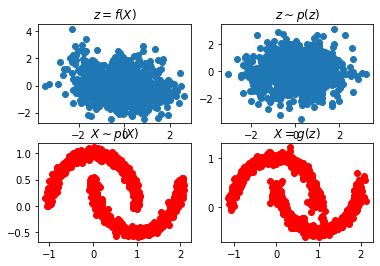

In [10]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)
batch = torch.tensor(
      noisy_moons[0],
      dtype=torch.float32,
      device=device
  )
z = flow.f(batch)[0].detach().cpu().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000)
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

## Provide answers for the folowing questions:

In [38]:
def get_flow_model(
    x_dim=2, hidden_dim=256, n_layers=3, 
    s_last_activation='tanh', t_last_activation='none',
    number_of_coupling_layers=6, device=device):

    nets = partial(
        get_net, x_dim=x_dim, hidden_dim=hidden_dim,
        n_layers=n_layers, last_activation=s_last_activation
    )
    nett = partial(
        get_net, x_dim=x_dim, hidden_dim=hidden_dim,
        n_layers=n_layers, last_activation=t_last_activation
    )

    masks = get_masks(number_of_coupling_layers=number_of_coupling_layers)
    prior = MultivariateNormal(torch.zeros(x_dim, device=device), torch.eye(x_dim, device=device))

    return RealNVP(nets, nett, masks, prior).to(device)

In [29]:
args = {}
train_args = {}
def clear():
    global args, train_args
    #изначальные параметры
    args = {
        'x_dim': 2,
        'hidden_dim': 256,
        'n_layers': 3,
        's_last_activation': 'tanh',
        't_last_activation': 'none',
        'number_of_coupling_layers': 6,
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }

    train_args = {
        'batch_size': 100,
        'steps': 5001,
        'lr': 1e-3
    }

Tranning:   0%|          | 0/5001 [00:00<?, ?it/s]

iter 0: loss = 2.316
iter 500: loss = 0.555
iter 1000: loss = 0.516
iter 1500: loss = 0.617
iter 2000: loss = 0.532
iter 2500: loss = 0.489
iter 3000: loss = 0.599
iter 3500: loss = 0.517
iter 4000: loss = 0.569
iter 4500: loss = 0.508
iter 5000: loss = 0.457


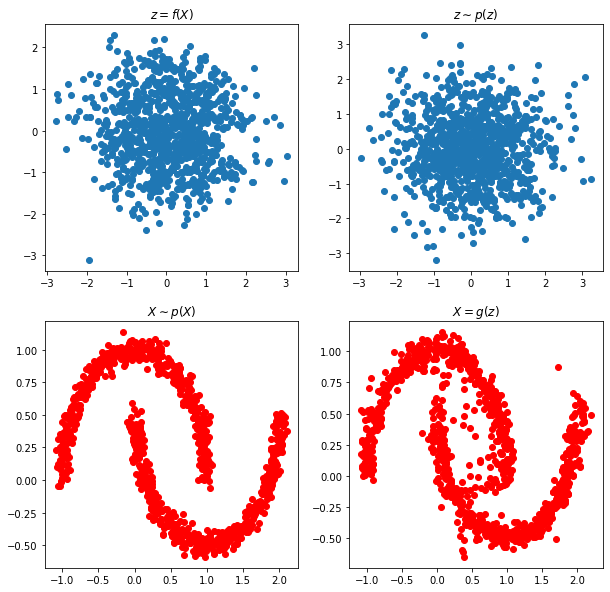

In [13]:
flow = get_flow_model(**args)
flow.fit(**train_args)
flow.visualization(n_samples=1000)

Tranning:   0%|          | 0/5001 [00:00<?, ?it/s]

iter 0: loss = 2.517
iter 500: loss = 0.523
iter 1000: loss = 0.497
iter 1500: loss = 0.341
iter 2000: loss = 0.411
iter 2500: loss = 0.612
iter 3000: loss = 0.616
iter 3500: loss = 0.339
iter 4000: loss = 0.338
iter 4500: loss = 0.386
iter 5000: loss = 0.506


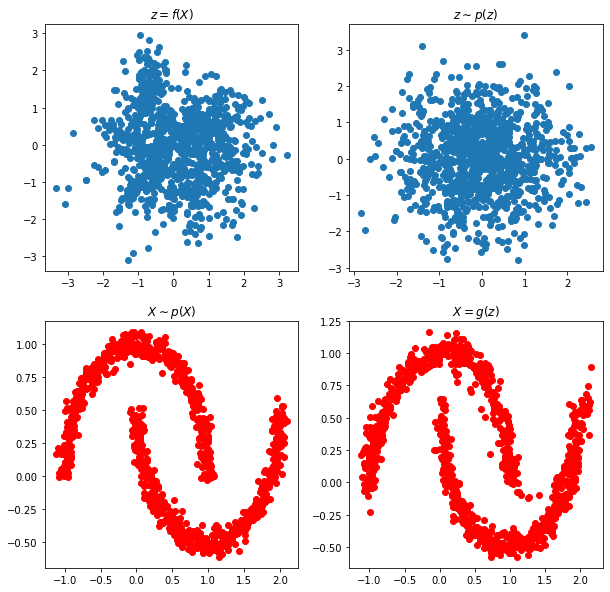

In [41]:
# увеличим количество слоев
clear()
args['n_layers'] = 5

flow = get_flow_model(**args)
flow.fit(**train_args)
flow.visualization(n_samples=1000)

Tranning:   0%|          | 0/5001 [00:00<?, ?it/s]

iter 0: loss = 2.615
iter 500: loss = 0.861
iter 1000: loss = 0.867
iter 1500: loss = 0.681
iter 2000: loss = 0.751
iter 2500: loss = 0.635
iter 3000: loss = 0.733
iter 3500: loss = 0.918
iter 4000: loss = 0.736
iter 4500: loss = 0.797
iter 5000: loss = 0.744


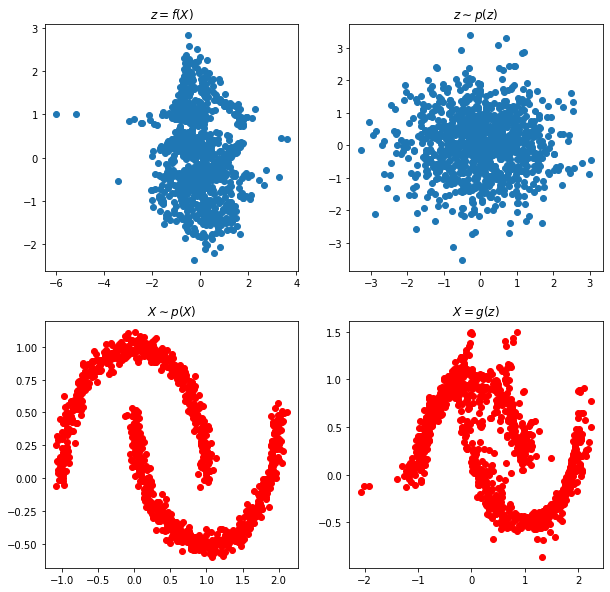

In [39]:
# уменьшим количество масок 
clear()
args['number_of_coupling_layers'] = 3

flow = get_flow_model(**args)
flow.fit(**train_args)
flow.visualization(n_samples=1000)

Tranning:   0%|          | 0/5001 [00:00<?, ?it/s]

iter 0: loss = 2.438
iter 500: loss = 0.419
iter 1000: loss = 0.601
iter 1500: loss = 0.421
iter 2000: loss = 0.570
iter 2500: loss = 0.392
iter 3000: loss = 0.428
iter 3500: loss = 0.479
iter 4000: loss = 0.446
iter 4500: loss = 0.322
iter 5000: loss = 0.429


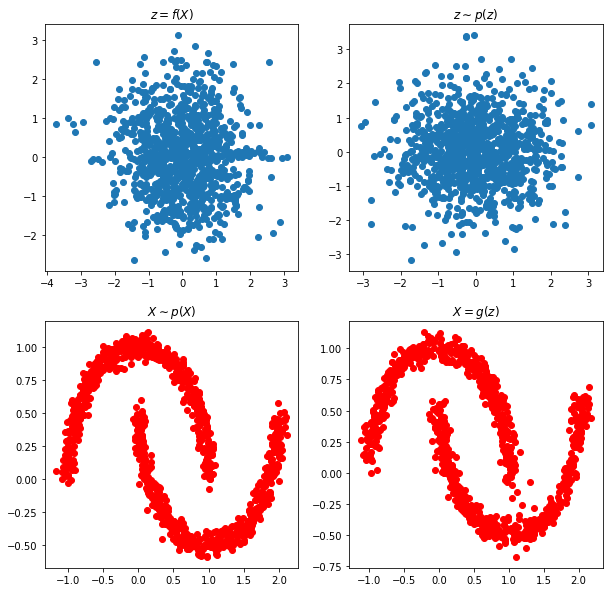

In [40]:
# увеличим количество масок 
clear()
args['number_of_coupling_layers'] = 9

flow = get_flow_model(**args)
flow.fit(**train_args)
flow.visualization(n_samples=1000)

Tranning:   0%|          | 0/5001 [00:00<?, ?it/s]

iter 0: loss = 2.558
iter 500: loss = 1.095
iter 1000: loss = 0.825
iter 1500: loss = 0.735
iter 2000: loss = 0.639
iter 2500: loss = 0.541
iter 3000: loss = 0.510
iter 3500: loss = 0.676
iter 4000: loss = 0.428
iter 4500: loss = 0.476
iter 5000: loss = 0.531


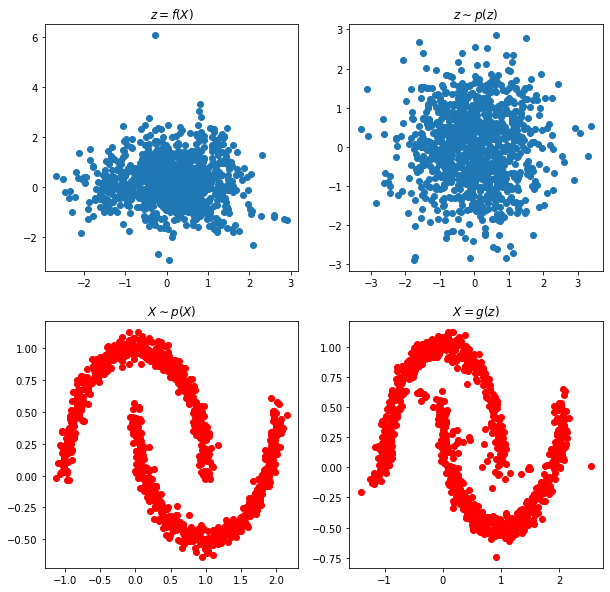

In [16]:
# попробуем убрать тангенс
clear()
args['s_last_activation'] = 'none'

flow = get_flow_model(**args)
flow.fit(**train_args)
flow.visualization(n_samples=1000)

Tranning:   0%|          | 0/5001 [00:00<?, ?it/s]

iter 0: loss = 2.668
iter 500: loss = 0.531
iter 1000: loss = 0.508
iter 1500: loss = 0.611
iter 2000: loss = 0.480
iter 2500: loss = 0.791
iter 3000: loss = 0.409
iter 3500: loss = 0.431
iter 4000: loss = 0.455
iter 4500: loss = 0.472
iter 5000: loss = 0.505


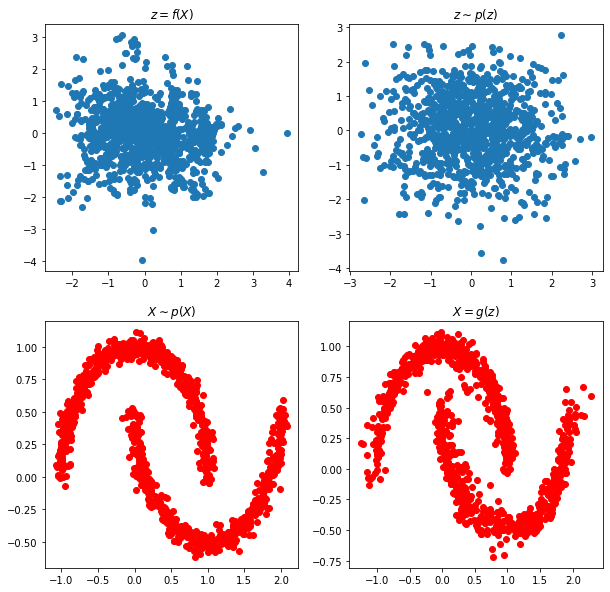

In [18]:
#добавим ограничение на смещение
clear()
args['t_last_activation'] = 'tanh'


flow = get_flow_model(**args)
flow.fit(**train_args)
flow.visualization(n_samples=1000)

1. What architecture worked better in your experiments?

Большое количество масок приводит к сложности восстановления распределения данных, что кажется логичным. Почему-то увелечение слоев в сети влияет на результат семплинга в худшую сторону, что для меня кажется странным результатом.

Ограничение последних активаций в s и t приводит к лучшим визуальным результатм.

Лоссы при любых параметрах ведут себя примерно одинаково.

2. Did you find what is important for stable training (initializations, nonlinearities, ...)?

Вверху было предупреждение, что в конце сети s должен быть тангенс, но если его убрать это не приводит к нестабильному обучению.

Ограничение t и s приводит к лучшему визуальному результату

3. How convergence speed (in iterations) depends on the complexity of architecture?

Если маленькое количество масок, то плохо сходится. Большое количество масок приводит к лучшей сходимости, но работает это медленнее.

Аналогично с количеством слоев в сети. Большее количество приводит к лучшей сходимости.

# Optional Research Assignments:

This assignment is optional. It will give you up to 2 additional points for one of the assignments.   
#### 1. VAE: 
Use normalizing flow to get more expressive $q(z\,|\,x)$,  https://arxiv.org/abs/1505.05770. TL;dr; use decoder to predict $z_0 \sim q_0(z_0|x)$, then use NF to obtain $z_k = f_k \circ \dots \circ f_1(z)$ sample from a more flexible distribution. Compare it with a conventional normal distribution, what is working better? Compare it with conventional VAE  that uses the same number of parameters as VAE with NF.

#### 2. More complex data: 
Train NFs for a more complex dataset e.g. MNIST (downscale is possible), make samples look reasonable e.g., solid fraction of samples can be recognized as a valid digits. Worth to use Conv2d layers for s and t.
